In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
sys.path.append("../..")

from scipy.sparse.linalg import aslinearoperator

from pytikhonov import piecewise_constant_1d_test_problem, first_order_derivative_1d, gaussian_1d_blur_matrix
from pytikhonov import lcorner, TikhonovFamily, ProjectedTikhonovFamily, discrepancy_principle, lcorner, find_lcurve_corner, plot_rdata, picard_plot, gcvmin, all_regparam_methods
from pytikhonov import rand_discrepancy_principle, rand_lcurve, rand_lcorner, rand_gcvmin
from pytikhonov import plot_gcv, plot_dp, plot_lcorner, plot_all_methods, picard_plot
from pytikhonov import golub_kahan
from pytikhonov import estimate_noise_variance, plot_monitoring_function

In [2]:
# Problem parameters
blur_sigma = 8.0

# Build toy problem
xtrue = piecewise_constant_1d_test_problem()
N = len(xtrue)
A = gaussian_1d_blur_matrix(N, blur_sigma=blur_sigma, mode="constant")
noise_sigma = 1e-1
btrue = A @ xtrue
np.random.seed(0)
noise_vec = noise_sigma*np.random.normal(size=len(btrue))
b = btrue + noise_vec  # signal and noise
L, _ = first_order_derivative_1d(N, boundary="none")
L = L.toarray()

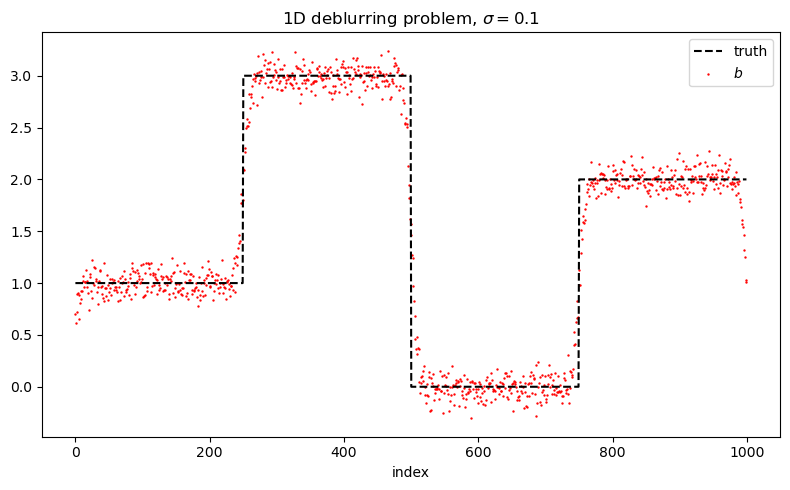

In [3]:
idx = [i for i in range(len(b))]
plt.figure(figsize=(8,5))
plt.plot(xtrue, label="truth", ls="--", color="k")
plt.scatter(idx, b, label="$b$", color="red", s=0.5)
plt.legend()
plt.xlabel("index")
plt.title(f"1D deblurring problem, $\sigma = {noise_sigma}$")
#plt.plot(dp_data["x_lambdah"], color="blue", label="DP solution")
plt.tight_layout()
plt.savefig("deblur_data.png", dpi=250, bbox_inches=None)
plt.show()

# Build TikhonovFamily

In [4]:
# Define the Tikhonov family (computes GSVD upon instantiation)
tf = TikhonovFamily(A, L, b, None, btrue=btrue, noise_var=noise_sigma**2)
gsvd = tf.gsvd

In [5]:
# Also define it without giving access to noise variance
tf_no_noise = TikhonovFamily(A, L, btrue, None, btrue=None, noise_var=None, gsvd=gsvd)

# Interfacing with TikhonovFamily

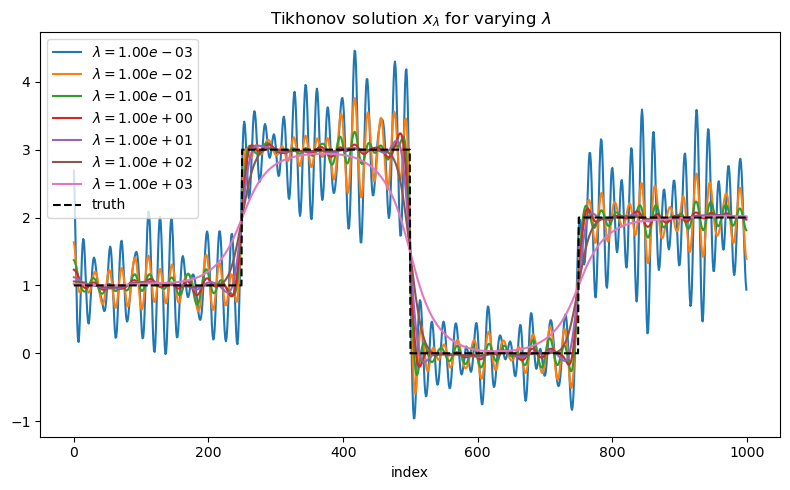

In [8]:
idx = [i for i in range(len(b))]
plt.figure(figsize=(8,5))
lambdahs = np.logspace(-3, 3, num=7, base=10)


for lam in lambdahs:
    plt.plot(idx, tf.solve(lam), label=f"$\lambda = {lam:.2e}$")

plt.plot(xtrue, label="truth", ls="--", color="k")
#plt.scatter(idx, b, label="$b$", color="red", s=0.5)
plt.legend()
plt.xlabel("index")
plt.title(f"Tikhonov solution $x_{{\lambda}}$ for varying $\lambda$")
#plt.plot(dp_data["x_lambdah"], color="blue", label="DP solution")
plt.tight_layout()
plt.savefig("deblur_tf.png", dpi=250, bbox_inches=None)
plt.show()

In [9]:
# Query derivatives of data fidelity and regularization terms
lambdahs = np.logspace(-3, 3, num=7, base=10)
data_fidelities = tf.data_fidelity(lambdahs, reciprocate=False)
regularization_terms = tf.regularization_term(lambdahs, reciprocate=False)

In [10]:
# Derivatives
order = 1

data_fidelities_derivs = tf.data_fidelity_derivative(lambdahs, order=1, reciprocate=False)
regularization_terms_derivs = tf.regularization_term_derivative(lambdahs, order=1, reciprocate=False)

data_fidelities_derivs = tf.data_fidelity_derivative(lambdahs, order=1, reciprocate=False)
regularization_terms_derivs = tf.regularization_term_derivative(lambdahs, order=1, reciprocate=False)

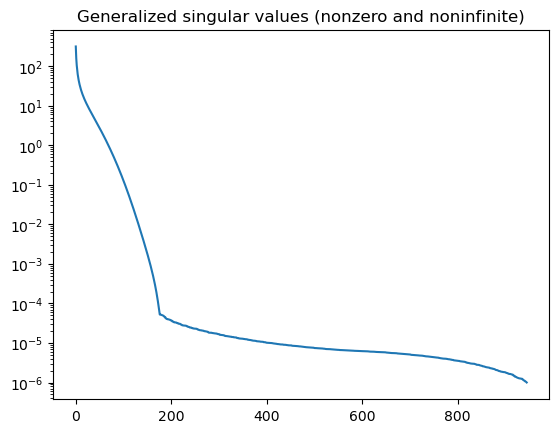

In [11]:
plt.semilogy(tf.gsvd.gamma_check)
plt.title("Generalized singular values (nonzero and noninfinite)")
plt.show()

# Plot the L-curve?

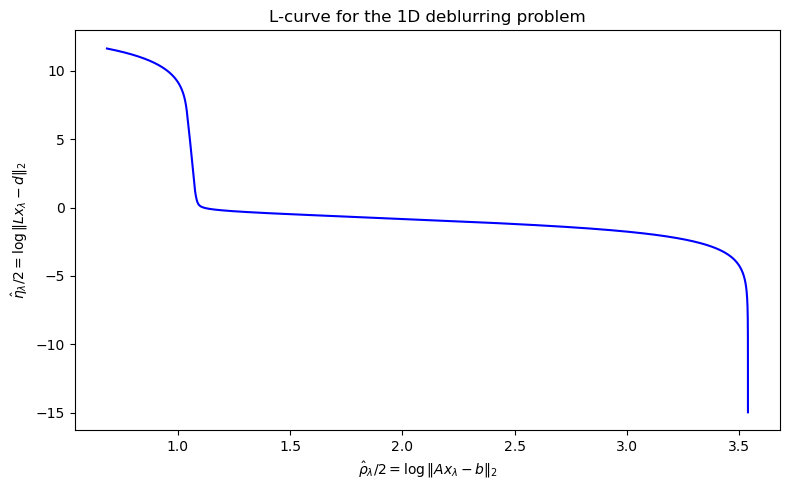

In [12]:
lambdahs = np.logspace(-10, 10, num=1000, base=10)
rho_hat_half, eta_hat_half = tf.lcurve(lambdahs)

plt.figure(figsize=(8,5))
plt.plot(rho_hat_half, eta_hat_half, color="blue")
plt.xlabel("$\hat{\\rho}_{\lambda}/2 = \log \| A x_{\lambda} - b \|_2$")
plt.ylabel("$\hat{\\eta}_{\lambda}/2 = \log \| L x_{\lambda} - d \|_2$")
plt.title("L-curve for the 1D deblurring problem")
plt.tight_layout()
plt.savefig("deblur_lcurve.png", dpi=250, bbox_inches=None)
plt.show()

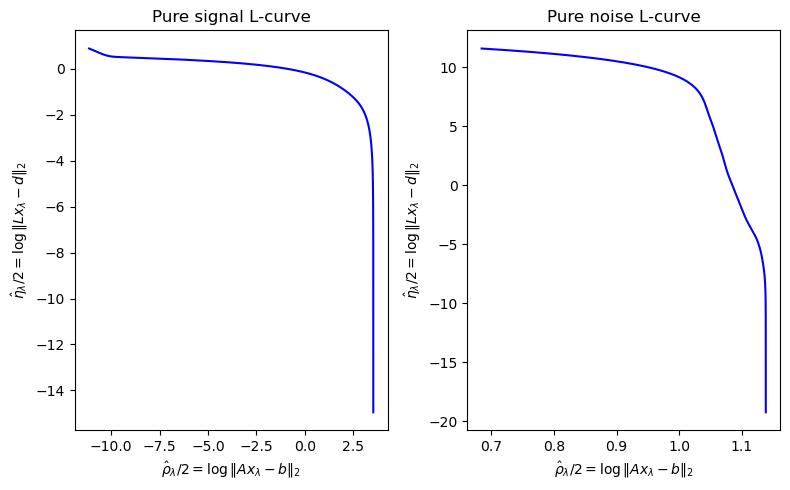

In [13]:
# Plot "pure signal" and "pure noise" L-curves
tf_pure_noise = TikhonovFamily(A, L, noise_vec, None, btrue=btrue, noise_var=noise_sigma**2, gsvd=gsvd)
tf_pure_signal = TikhonovFamily(A, L, btrue, None, btrue=btrue, noise_var=noise_sigma**2, gsvd=gsvd)

lambdahs = np.logspace(-10, 10, num=1000, base=10)

fig, axs = plt.subplots(1, 2, figsize=(8,5))

rho_hat_half, eta_hat_half = tf_pure_noise.lcurve(lambdahs)
axs[1].plot(rho_hat_half, eta_hat_half, color="blue")
axs[1].set_xlabel("$\hat{\\rho}_{\lambda}/2 = \log \| A x_{\lambda} - b \|_2$")
axs[1].set_ylabel("$\hat{\\eta}_{\lambda}/2 = \log \| L x_{\lambda} - d \|_2$")
axs[1].set_title("Pure noise L-curve")

rho_hat_half, eta_hat_half = tf_pure_signal.lcurve(lambdahs)
axs[0].plot(rho_hat_half, eta_hat_half, color="blue")
axs[0].set_xlabel("$\hat{\\rho}_{\lambda}/2 = \log \| A x_{\lambda} - b \|_2$")
axs[0].set_ylabel("$\hat{\\eta}_{\lambda}/2 = \log \| L x_{\lambda} - d \|_2$")
axs[0].set_title("Pure signal L-curve")


fig.tight_layout()
fig.savefig("deblur_lcurve_pure_noise_signal.png", dpi=250, bbox_inches=None)
plt.show()

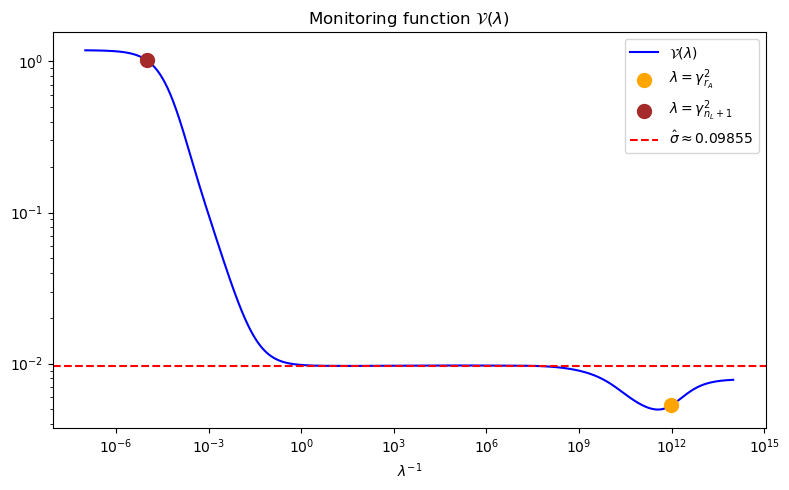

In [14]:
# Plot monitoring function when there is noise in the RHS
plot_monitoring_function(tf, plot_path="deblur_monitoring_func.png")
plot_monitoring_function(tf, plot_path=None)

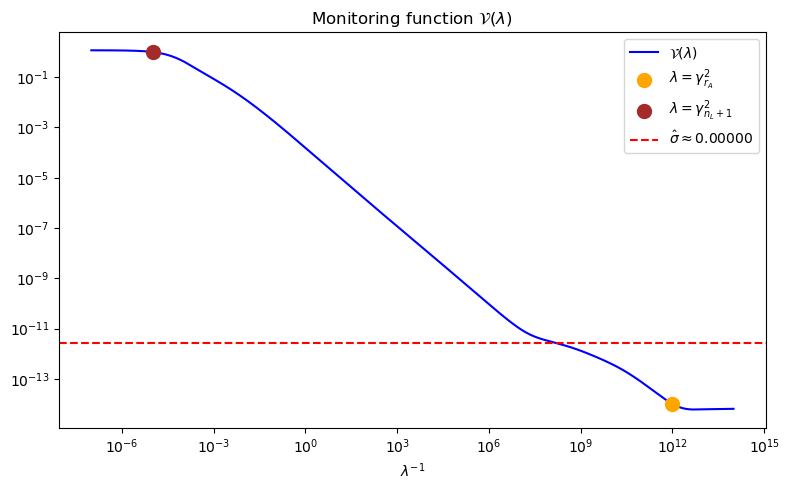

In [19]:
# Plot monitoring function when there is no noise in the RHS
plot_monitoring_function(tf_pure_signal, plot_path="deblur_monitoring_func_no_noise.png")
plot_monitoring_function(tf_pure_signal, plot_path=None)

In [20]:
# Estimate noise variance according to the monitoring function
estimate_noise_variance(tf)

np.float64(0.00971271073132142)

In [21]:
# Actual noise variance
noise_sigma**2

0.010000000000000002

# Picard plot

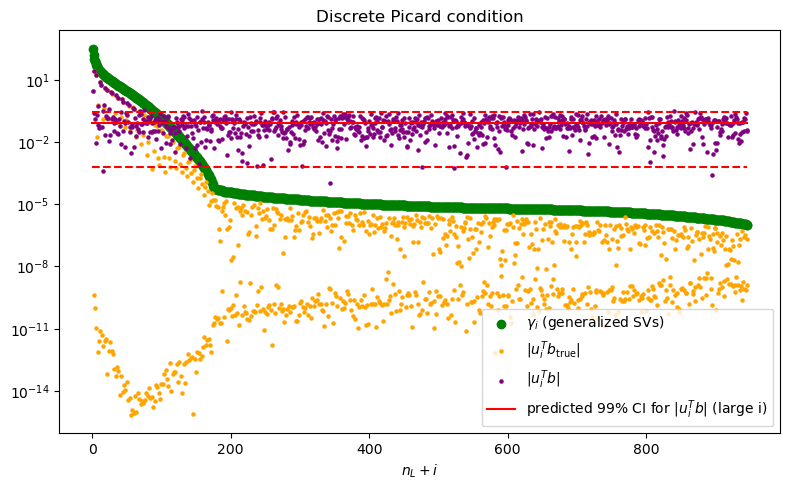

In [18]:
# Generate the picard plot when there is knowledge of the noise variance
picard_plot(tf, plot_path="deblur_picard.png")
picard_plot(tf, plot_path=None)

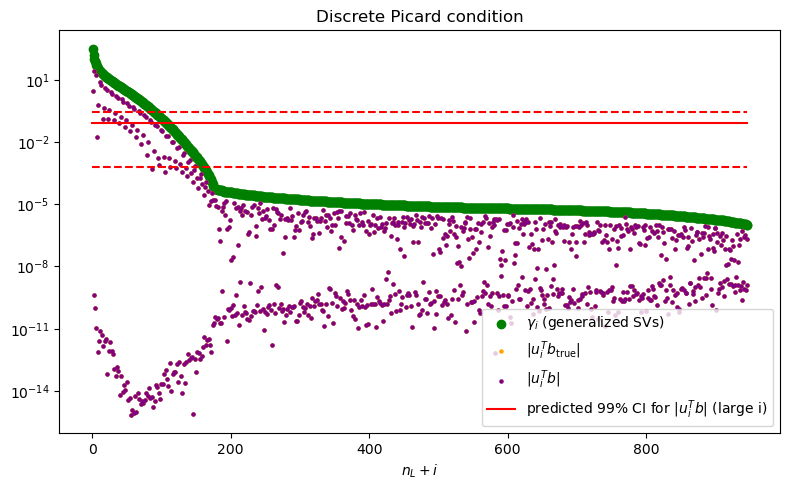

In [22]:
# Generate the picard plot when there is no knowledge of the noise variance
picard_plot(tf_pure_signal, plot_path="deblur_picard_novar.png")
picard_plot(tf_pure_signal, plot_path=None)

# L-corner

In [19]:
# Select parameter according to lcorner method
ldata = lcorner(tf)

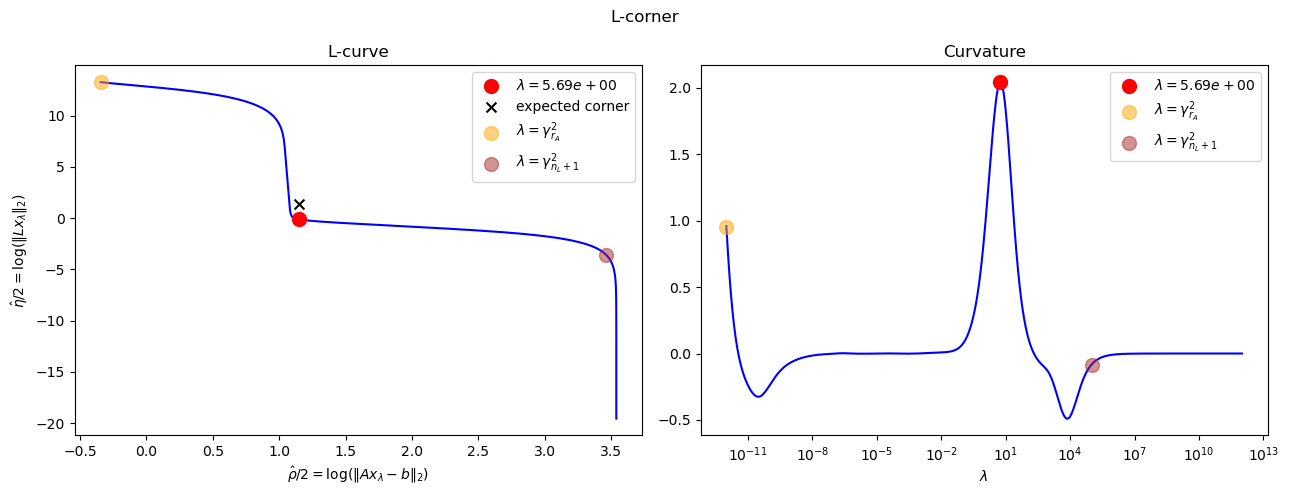

In [20]:
plot_lcorner(ldata, plot_path="deblur_lcorner.png")
plot_lcorner(ldata, plot_path=None)

# DP method

In [26]:
# Select parameter according to lcorner method
dp_data = discrepancy_principle(tf)

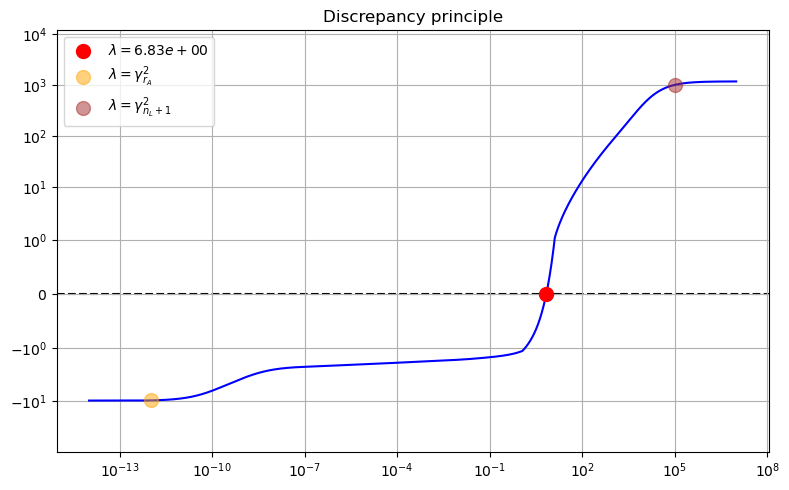

In [27]:
plot_dp(dp_data, plot_path="deblur_dp.png")
plot_dp(dp_data, plot_path=None)

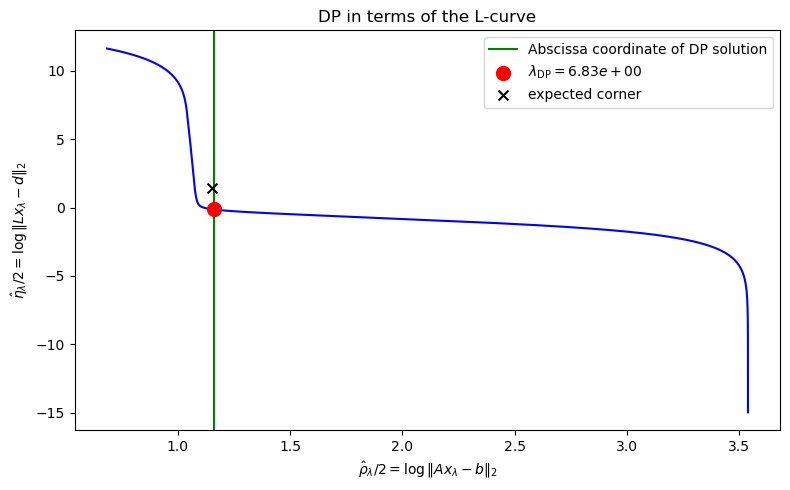

In [29]:
# Visualize DP result in terms of the L-curve
lambdahs = np.logspace(-10, 10, num=1000, base=10)
rho_hat_half, eta_hat_half = tf.lcurve(lambdahs)


plt.figure(figsize=(8,5))
plt.plot(rho_hat_half, eta_hat_half, color="blue")
plt.xlabel("$\hat{\\rho}_{\lambda}/2 = \log \| A x_{\lambda} - b \|_2$")
plt.ylabel("$\hat{\\eta}_{\lambda}/2 = \log \| L x_{\lambda} - d \|_2$")
plt.title("DP in terms of the L-curve")
plt.axvline(0.5*np.log(A.shape[0]*(noise_sigma**2)*(1.01**2)), color="green", label="Abscissa coordinate of DP solution")
opt_lambdah = dp_data["opt_lambdah"]
plt.scatter(dp_data["opt_rho_hat"]/2.0, dp_data["opt_eta_hat"]/2.0, color="red", s=100, zorder=10, label=f"$\lambda_{{\\text{{DP}}}} = {opt_lambdah:.2e}$")
plt.scatter( 0.5*np.log(  (A.shape[0] - tf.n_L)*(noise_sigma**2)  ), 0.5*np.log( tf.d_hat_perp_norm_squared + (((tf.U2.T @ btrue)**2)/(tf.gamma_check**2)).sum() ) , s=50, zorder=10, color="black", marker="x", label="expected corner" )
plt.legend()
plt.tight_layout()
plt.savefig("deblur_lcurve_with_dp.png", dpi=250, bbox_inches=None)
plt.show()

# GCV

In [30]:
gcv_data = gcvmin(tf)

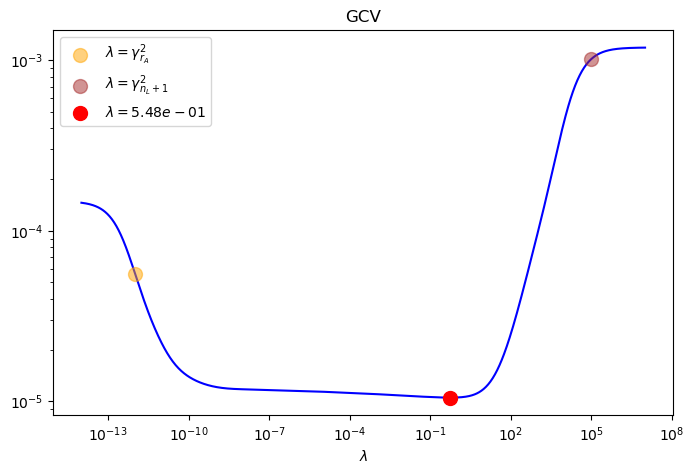

In [31]:
plot_gcv(gcv_data, plot_path="deblur_gcv.png")
plot_gcv(gcv_data, plot_path=None)

# Comparing regularization parameter selection methods

In [33]:
# Run all methods
all_methods = all_regparam_methods(tf)

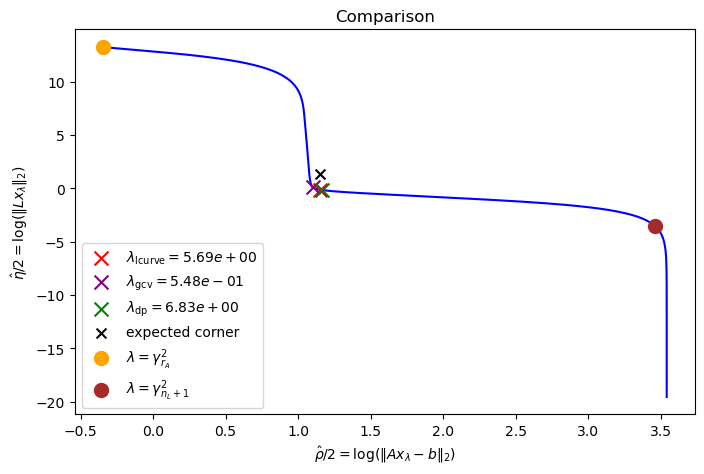

In [34]:
plot_all_methods(all_methods)
plot_all_methods(all_methods, plot_path="deblur_all_methods.png")

In [35]:
# Run randomization experiment
dp_lambdahs, dp_e_norms = rand_discrepancy_principle(tf, n_samples=1000)
lcorner_lambdahs, lcorner_e_norms = rand_lcorner(tf, n_samples=1000)
gcvmin_lambdahs, gcvmin_e_norms = rand_gcvmin(tf, n_samples=1000)

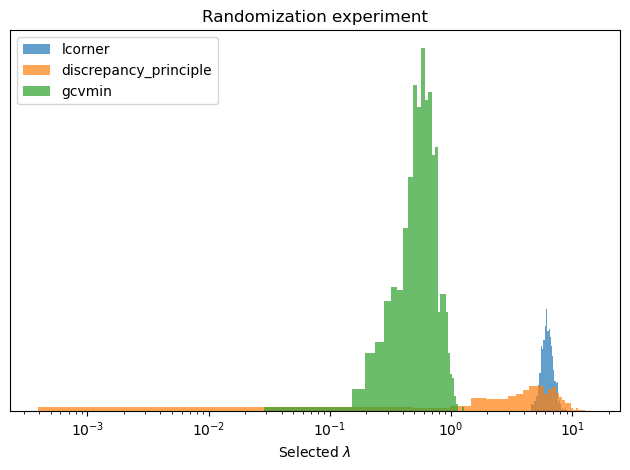

In [36]:
plt.hist(lcorner_lambdahs, bins=30, label="lcorner", density=True, alpha=0.7)
plt.hist(dp_lambdahs, bins=30, label="discrepancy_principle", density=True, alpha=0.7)
plt.hist(gcvmin_lambdahs, bins=30, label="gcvmin", density=True, alpha=0.7)
plt.yticks([])
plt.xscale("log")
plt.legend()
plt.title("Randomization experiment")
plt.xlabel("Selected $\lambda$")
plt.tight_layout()
plt.savefig("deblur_randomization_experiment.png", dpi=250, bbox_inches=None)
plt.show()

# Iteratively reweighted least-squares (IRLS)

In [58]:
# Define weighting scheme
def lp_weights(x, epsilon, p):
    z = (x**2 + epsilon**2)**( (p-2.0)/2.0 )
    return z

l1_weighting_rule = lambda Lx: np.sqrt(lp_weights(Lx, 1e-3, 1.0))

# Initial guess and weights 
x_irls = b.copy()
w_irls = l1_weighting_rule(L @ x_irls)

# Run iteration
n_iters = 20
lambdah_history = []
ldata_history = []
tf_irls_history = []
for j in range(n_iters):

    # Solve current problem
    tf_irls = TikhonovFamily(A, np.diag(w_irls) @ L, b, d=None, noise_var=noise_sigma**2)
    ldata = lcorner(tf_irls)

    # Update weights
    x_irls = ldata["x_lambdah"]
    opt_lambdah = ldata["opt_lambdah"]
    print(opt_lambdah)
    lambdah_history.append(opt_lambdah)
    ldata_history.append(ldata)
    tf_irls_history.append(tf_irls)
    w_irls = l1_weighting_rule(L @ x_irls)

0.8176718504689465
1.2096520279953242
1.4636124298632254
1.3806236570960237
1.3183666496145192
1.2741868728818215
1.2424617825986848
1.2192368092966044
1.201770794850325
1.1881707521881417
1.1772602056364294
1.1682938287992906
1.1607850297041904
1.1544036924644192
1.1489021213543589
1.1441032518635486
1.1398662128387742
1.1360885138051449
1.1326997445321199
1.1296317487260954


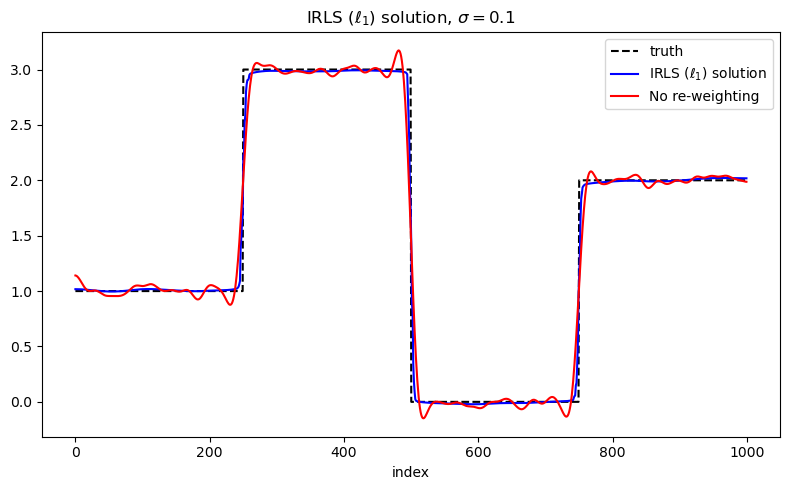

In [59]:
idx = [i for i in range(len(b))]
plt.figure(figsize=(8,5))
plt.plot(idx, xtrue, label="truth", ls="--", color="k")
plt.plot(idx, x_irls, label="IRLS ($\ell_1$) solution", ls="-", color="blue")
ldata = lcorner(tf)
plt.plot(idx, ldata["x_lambdah"], label="No re-weighting", ls="-", color="red")
plt.legend()
plt.xlabel("index")
plt.title(f"IRLS ($\ell_1$) solution, $\sigma = {noise_sigma}$")
plt.tight_layout()
plt.savefig("deblur_irls_data.png", dpi=250, bbox_inches=None)
plt.show()

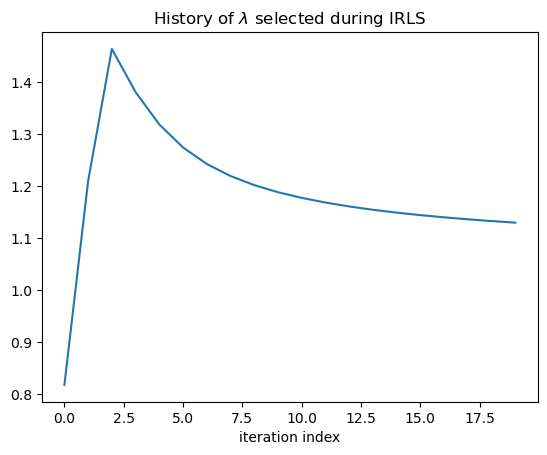

In [60]:
plt.title("History of $\lambda$ selected during IRLS")
plt.plot(lambdah_history)
plt.xlabel("iteration index")
plt.show()

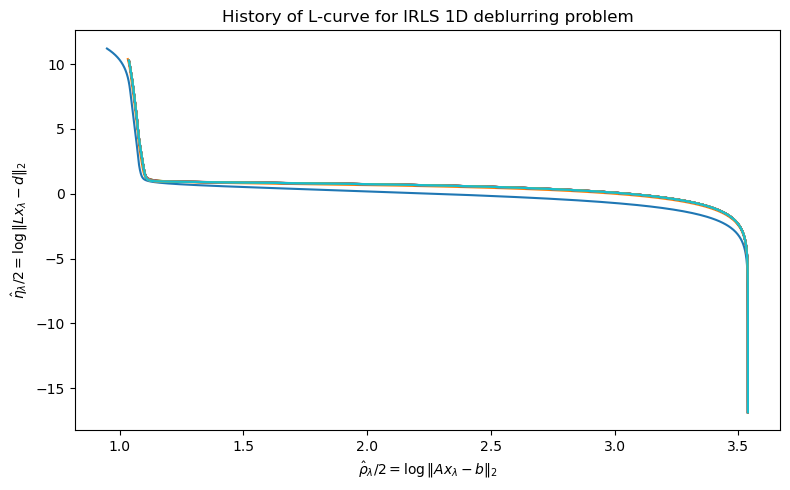

In [65]:
lambdahs = np.logspace(-10, 10, num=1000, base=10)

plt.figure(figsize=(8,5))
for j in range(n_iters):
    rho_hat_half, eta_hat_half = tf_irls_history[j].lcurve(lambdahs)

    plt.plot(rho_hat_half, eta_hat_half, color=f"C{j}")

plt.xlabel("$\hat{\\rho}_{\lambda}/2 = \log \| A x_{\lambda} - b \|_2$")
plt.ylabel("$\hat{\\eta}_{\lambda}/2 = \log \| L x_{\lambda} - d \|_2$")
plt.title("History of L-curve for IRLS 1D deblurring problem")
plt.tight_layout()
plt.show()

# With projection?

In [6]:
# Define V and x_under
_, V, _, _, _, _ = golub_kahan( aslinearoperator(A), b, 25, reorth="mgs2", tol=1e-12)
x_under = None

In [8]:
# Define projected Tikhonov family
ptf = ProjectedTikhonovFamily( aslinearoperator(A), aslinearoperator(L), V=V, b=b, x_under=x_under, noise_var=noise_sigma**2)

# Or alternatively project the original one
ptf = tf.project(V, x_under)

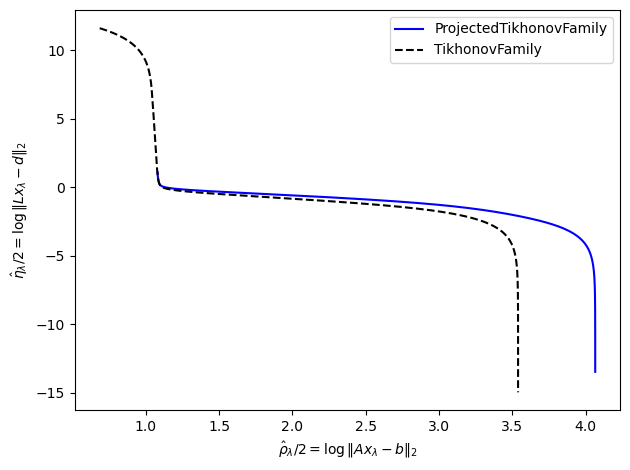

In [10]:
# Plot difference in L-curves

lambdahs = np.logspace(-10, 10, num=1000, base=10)

rho_hat_half, eta_hat_half = ptf.lcurve(lambdahs)
plt.plot(rho_hat_half, eta_hat_half, label="ProjectedTikhonovFamily", color="blue")

rho_hat_half, eta_hat_half = tf.lcurve(lambdahs)
plt.plot(rho_hat_half, eta_hat_half, label="TikhonovFamily", ls="--", color="black")

plt.legend()
plt.xlabel("$\hat{\\rho}_{\lambda}/2 = \log \| A x_{\lambda} - b \|_2$")
plt.ylabel("$\hat{\\eta}_{\lambda}/2 = \log \| L x_{\lambda} - d \|_2$")
plt.tight_layout()
plt.savefig("deblur_projected_lcurve.png", dpi=250, bbox_inches=None)
plt.show()

In [11]:
lcorner_data = lcorner(ptf)

In [13]:
dp_data = discrepancy_principle(ptf)